# BRI data scRNA analysis in Python - deep clean data
## make psedubulk data by AIFI l3 labels for all aims
<a name = "contents"></a>

### Contents

- [Importing packages](#Importing-packages)
- [Reading h5 files](#Reading-h5-files)
    - [Gene x cell matrix](#Gene-x-cell-matrix)
    - [Observation metadata](#Observation-metadata)
- [Assembling AnnData](#Assembling-AnnData)
- [Combining multiple files](#Combining-multiple-files)
- [Saving and loading AnnData](#Saving-and-loading-AnnData)
- [Basic analysis with scanpy](#Basic-analysis-with-scanpy)
- [Session Info](#Session-Info)

In [1]:
import h5py
import scipy.sparse as scs
import pandas as pd
import anndata
import os
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation
import scanpy as sc
import random
# import sc_toolbox
# import pertpy 
import decoupler as dc
import anndata as ad

In [2]:
anndata.__version__
dc.__version__

'1.8.0'

In [3]:
# sc.settings.n_jobs = 58

In [4]:
# define some color patterns for plotting
nejm_color = ["#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF"]
jama_color = ["#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF"]

In [5]:
# define working path
data_path = '/home/jupyterdata/immune_health/scRNA/BRI/h5ad/sample_h5ad/'
meta_path = '/home/jupyter/data/immune_health/'
fig_path = '/home/jupyter/data/ra_longitudinal/figures/BRI/'
output_path = '/home/jupyter/data/immune_health/output_results/'
# os.mkdir(fig_path)
# os.mkdir(output_path)
# define a project name
proj_name = 'BRI_scRNA_AIFI_L2_deepclean_Pseudobulk_'
# sc.set_figure_params(fig_path)
sc.settings.figdir = fig_path
sc.settings.autosave=False
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [6]:
# import the helper functions
# importing the sys module
import sys         
 
# appending the directory of mod.py 
# in the sys.path list
sys.path.append('/home/jupyter/github/ra-longitudinal/scRNA/')        
# now we can import mod

from ALTRA_scRNA_py_helper_functions import generate_pseudobulk_data

# Perform DEG analysis longitudinal analysis based on the cell types

In [7]:
# load the samples selection
bri_meta = pd.read_csv(meta_path + 'BRI_longitudinal_matching_converters_090324.csv')

In [8]:
len(bri_meta['subject.subjectGuid'].unique())

29

In [9]:
bri_meta['file_path']

0     /home/jupyter/data/immune_health/scRNA/BRI/h5a...
1     /home/jupyter/data/immune_health/scRNA/BRI/h5a...
2     /home/jupyter/data/immune_health/scRNA/BRI/h5a...
3     /home/jupyter/data/immune_health/scRNA/BRI/h5a...
4     /home/jupyter/data/immune_health/scRNA/BRI/h5a...
                            ...                        
81    /home/jupyter/data/immune_health/scRNA/BRI/h5a...
82    /home/jupyter/data/immune_health/scRNA/BRI/h5a...
83    /home/jupyter/data/immune_health/scRNA/BRI/h5a...
84    /home/jupyter/data/immune_health/scRNA/BRI/h5a...
85    /home/jupyter/data/immune_health/scRNA/BRI/h5a...
Name: file_path, Length: 86, dtype: object

In [10]:
# read all the files
adata = [sc.read_h5ad(filename) for filename in bri_meta['file_path']]

In [11]:
len(adata)

86

In [12]:
# merge them into a anndata file toghether
bri_adata = ad.concat(adata)

In [13]:
bri_adata

AnnData object with n_obs × n_vars = 1356099 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'

In [14]:
bri_adata.obs['AIFI_L3'].unique()

['GZMB- CD27+ EM CD4 T cell', 'ISG+ CD14 monocyte', 'GZMK+ Vd2 gdT', 'GZMB- CD27- EM CD4 T cell', 'CD56bright NK cell', ..., 'CMP cell', 'SOX4+ Vd1 gdT', 'BaEoMaP cell', 'CD4 MAIT', 'KLRF1- effector Vd1 gdT']
Length: 71
Categories (71, object): ['ASDC', 'Activated memory B cell', 'Adaptive NK cell', 'BaEoMaP cell', ..., 'Transitional B cell', 'Type 2 polarized memory B cell', 'cDC1', 'pDC']

In [15]:
bri_meta.loc[:,~bri_meta.columns.isin(adata[1].obs.columns)].columns

Index(['...1', 'X', 'lastUpdated', 'sample.id', 'sample.bridgingControl',
       'sample.visitDetails', 'sample.daysSinceFirstVisit', 'file.id',
       'file.name', 'file.batchID', 'file.panel', 'file.pool', 'file.fileType',
       'file.majorVersion', 'subject.id', 'subject.partnerCode',
       'sample.diseaseStatesRecordedAtVisit', 'pbmc_sample_id', 'Sample_ID',
       'Sample_Draw_date', 'Covid_Dose_1', 'Covid_Dose_2', 'Covid_exlcusion',
       'CMV.IgG.Serology.Result.Interpretation', 'BMI', 'file.name.downloaded',
       'file.path', 'sample_numbers', 'age', 'days_since_first', 'file_name',
       'file_path'],
      dtype='object')

In [16]:
# add metadata
meta_cols = ['age','BMI', 'sample.daysSinceFirstVisit',
                               'sample.diseaseStatesRecordedAtVisit',
                'days_since_first', 'file.batchID']
pd.Series(meta_cols).isin(bri_meta.loc[:,~bri_meta.columns.isin(adata[1].obs.columns)].columns)

0    True
1    True
2    True
3    True
4    True
5    True
dtype: bool

In [17]:
# add metadata
meta_cols.append('sample.sampleKitGuid')
bri_meta_add = bri_meta.loc[:,meta_cols]
bri_adata.obs = bri_adata.obs.merge(bri_meta_add, how='left', on='sample.sampleKitGuid')

In [18]:
# doouble check the raw counts data is stored in X
bri_adata.X[100:120, 500:520].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
bri_adata

AnnData object with n_obs × n_vars = 1356099 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'age', 'BMI', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'days_since_first', 'file.batchID'

In [20]:
# save the BRI matching single cell data
bri_adata.write_h5ad('/home/jupyter/data/immune_health/BRI_scRNA_AIFI_L3_deepclean_match_RAconv_090324.h5ad')

## Pseudobulk by cell type and smaples

In [21]:
# load the BRI matching single cell data
bri_adata = sc.read_h5ad('/home/jupyter/data/immune_health/BRI_scRNA_AIFI_L3_deepclean_match_RAconv_090324.h5ad')

/home/jupyter/libs/scvi/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
bri_adata

AnnData object with n_obs × n_vars = 1356099 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'age', 'BMI', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'days_since_first', 'file.batchID'

In [23]:
# define the cell type column 
# cell_type_col = 'celltypist_majority_label_pbmc'
cell_type_col = 'AIFI_L2'

In [24]:
bri_adata.obs.groupby(cell_type_col).size()

/tmp/ipykernel_13261/2204486110.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bri_adata.obs.groupby(cell_type_col).size()


AIFI_L2
ASDC                        355
CD8aa                      1597
CD14 monocyte            209963
CD16 monocyte             35238
CD56bright NK cell         8629
CD56dim NK cell          102324
DN T cell                  1770
Effector B cell            6433
Erythrocyte                1954
ILC                         545
Intermediate monocyte     10020
MAIT                      30555
Memory B cell             33899
Memory CD4 T cell        254766
Memory CD8 T cell        155977
Naive B cell              67440
Naive CD4 T cell         270298
Naive CD8 T cell          68935
Plasma cell                1821
Platelet                   6335
Progenitor cell            1003
Proliferating NK cell      2397
Proliferating T cell       2195
Transitional B cell        8011
Treg                      30754
cDC1                        707
cDC2                      11553
gdT                       25388
pDC                        5237
dtype: int64

In [25]:
# clean up the cell type names from R to python
# bri_adata.obs[cell_type_col] = [ct.replace(" ", "_") for ct in bri_adata.obs[cell_type_col]]

In [26]:
bri_adata

AnnData object with n_obs × n_vars = 1356099 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'age', 'BMI', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'days_since_first', 'file.batchID'

In [27]:
# make sure the count data are in X
# bri_adata.X = bri_adata.layers["counts"].copy()

In [28]:
# check to make sure this is count data
bri_adata.X[2000:2020, 1:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [29]:
# # format the metadata columns
# bri_adata.obs["sample.sampleKitGuid"] = bri_adata.obs["sample.sampleKitGuid"].astype("category")
# bri_adata.obs["subject.subjectGuid"] = bri_adata.obs["subject.subjectGuid"].astype("category")
# bri_adata.obs["subject.biologicalSex"] = bri_adata.obs["subject.biologicalSex"].astype("category")
# bri_adata.obs["file.batchID"] = bri_adata.obs["file.batchID"].astype("category")
# #bri_adata.obs["status"] = bri_adata.obs["status"].astype("category")
# bri_adata.obs[cell_type_col] = bri_adata.obs[cell_type_col].astype("category")
# bri_adata.obs["seurat_pbmc_type"] = bri_adata.obs["seurat_pbmc_type"].astype("category")

In [30]:
bri_adata[bri_adata.obs[cell_type_col]=='ASDC']

View of AnnData object with n_obs × n_vars = 355 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'age', 'BMI', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'days_since_first', 'file.batchID'

In [31]:
# use decoupler to make pseudobulk
adata_pb = dc.get_pseudobulk(bri_adata, sample_col="sample.sampleKitGuid", 
                             groups_col=cell_type_col, 
                             min_cells=10, min_counts=1000,
                              mode='sum')

In [32]:
# # use decoupler to make pseudobulk by average
# adata_pb = dc.get_pseudobulk(bri_adata, sample_col="sample.sampleKitGuid", 
#                              groups_col=cell_type_col, min_cells=10, min_counts=1000,
#                               mode='sum')

In [33]:
adata_pb.obs.groupby([cell_type_col]).size()

AIFI_L2
ASDC                      3
CD14 monocyte            86
CD16 monocyte            86
CD56bright NK cell       85
CD56dim NK cell          86
CD8aa                    41
DN T cell                66
Effector B cell          84
Erythrocyte              24
ILC                      21
Intermediate monocyte    85
MAIT                     85
Memory B cell            86
Memory CD4 T cell        86
Memory CD8 T cell        86
Naive B cell             84
Naive CD4 T cell         86
Naive CD8 T cell         86
Plasma cell              48
Platelet                 79
Progenitor cell          46
Proliferating NK cell    76
Proliferating T cell     69
Transitional B cell      85
Treg                     86
cDC1                     32
cDC2                     86
gdT                      86
pDC                      83
dtype: int64

<Axes: >

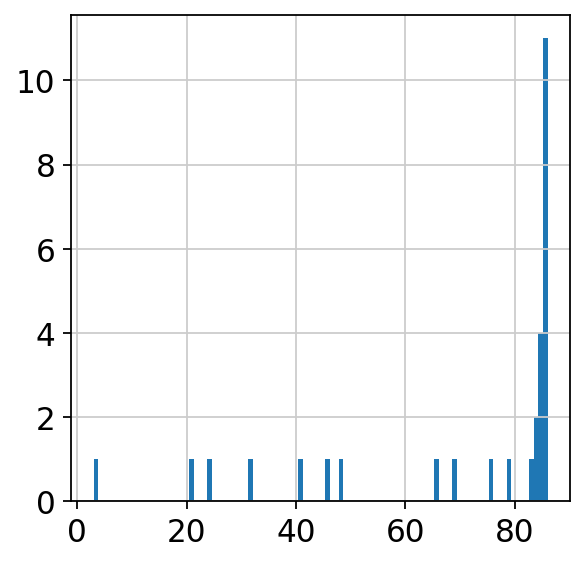

In [34]:
adata_pb.obs.groupby([cell_type_col]).size().hist(bins=100)

<Axes: >

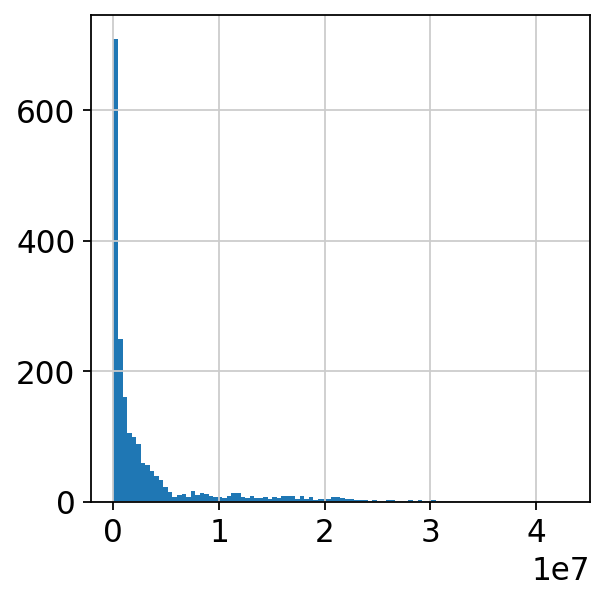

In [35]:
adata_pb.obs['psbulk_counts'].hist(bins=100)

<Axes: >

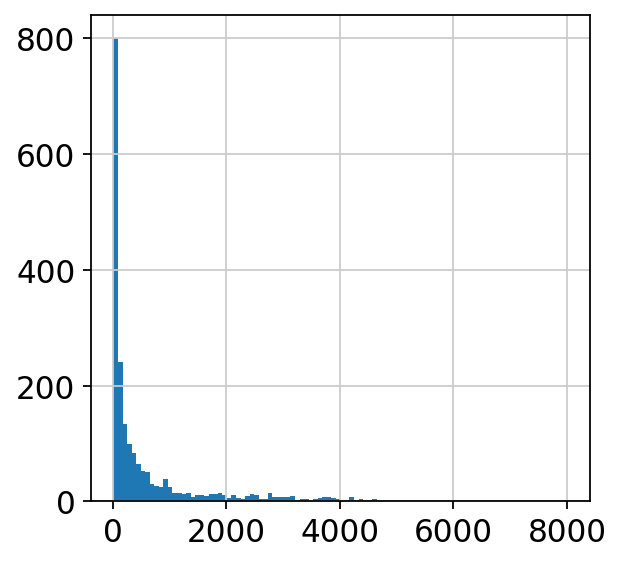

In [36]:
adata_pb.obs['psbulk_n_cells'].hist(bins=100)

In [37]:
adata_pb

AnnData object with n_obs × n_vars = 2042 × 29268
    obs: 'sample.sampleKitGuid', 'AIFI_L2', 'batch_id', 'pool_id', 'AIFI_L1', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'age', 'BMI', 'sample.daysSinceFirstVisit', 'days_since_first', 'file.batchID', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

In [38]:
adata_pb.layers['psbulk_props']

array([[0.35714286, 0.        , 0.        , ..., 0.28571429, 0.85714286,
        0.21428571],
       [0.45454545, 0.45454545, 0.        , ..., 0.27272727, 0.63636364,
        0.36363636],
       [0.31578947, 0.05263158, 0.        , ..., 0.31578947, 0.68421053,
        0.21052632],
       ...,
       [0.75409836, 0.06557377, 0.        , ..., 0.1147541 , 0.37704918,
        0.14754098],
       [0.91666667, 0.05555556, 0.        , ..., 0.11111111, 0.30555556,
        0.11111111],
       [0.76271186, 0.08474576, 0.        , ..., 0.05084746, 0.15254237,
        0.13559322]])

In [39]:
# adata_pb.var

In [40]:
# run and processing for the pseudobulk object
adata_pb.layers['counts'] = adata_pb.X.copy()
# sc.pp.normalize_total(adata_pb, target_sum=1e6)
# sc.pp.log1p(adata_pb)
# sc.pp.pca(adata_pb)

In [41]:
# calcualte the lib size
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1).astype(float)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

In [42]:
adata_pb.obs = adata_pb.obs.astype(str)

In [43]:
# save the h5ad file
adata_pb.write_h5ad(output_path+proj_name+'IH_l2_psbulk_090324.h5ad')

In [44]:
adata_pb

AnnData object with n_obs × n_vars = 2042 × 29268
    obs: 'sample.sampleKitGuid', 'AIFI_L2', 'batch_id', 'pool_id', 'AIFI_L1', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'age', 'BMI', 'sample.daysSinceFirstVisit', 'days_since_first', 'file.batchID', 'psbulk_n_cells', 'psbulk_counts', 'lib_size', 'log_lib_size'
    layers: 'psbulk_props', 'counts'

In [45]:
proj_name

'BRI_scRNA_AIFI_L2_deepclean_Pseudobulk_'

In [48]:
# load the h5ad file
adata_pb = sc.read_h5ad(output_path+proj_name+'IH_l2_psbulk_090324.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 2042 × 29268
    obs: 'sample.sampleKitGuid', 'AIFI_L2', 'batch_id', 'pool_id', 'AIFI_L1', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'age', 'BMI', 'sample.daysSinceFirstVisit', 'days_since_first', 'file.batchID', 'psbulk_n_cells', 'psbulk_counts', 'lib_size', 'log_lib_size'
    layers: 'counts', 'psbulk_props'

In [55]:
adata_pb.obs['subject.subjectGuid'].unique()

['BR1025', 'BR1013', 'BR1003', 'BR1008', 'BR2002', ..., 'BR1051', 'BR2046', 'BR1041', 'BR2052', 'BR2051']
Length: 29
Categories (29, object): ['BR1003', 'BR1008', 'BR1010', 'BR1013', ..., 'BR2042', 'BR2046', 'BR2051', 'BR2052']

In [ ]:
# combine with ALTRA L2 psedubulk data

In [49]:
# save the counts data for all samples
adata_pb_counts = pd.DataFrame(index=adata_pb.obs.index, columns=adata_pb.var.index,
                                           data=adata_pb.layers['counts'])
adata_pb_counts.to_csv(output_path + proj_name + '_counts.tsv', sep="\t")
# save the meta data
adata_pb.obs.to_csv(output_path + proj_name 
                                       +'_metadata.csv')

In [53]:
output_path + proj_name + '_counts.tsv'

'/home/jupyter/data/immune_health/scRNA/counts/BRI_scRNA_AIFI_L2_deepclean_Pseudobulk__counts.tsv'

## loop to make L2 cell type specific counts table and metadata

In [50]:
adata_pb

AnnData object with n_obs × n_vars = 2042 × 29268
    obs: 'sample.sampleKitGuid', 'AIFI_L2', 'batch_id', 'pool_id', 'AIFI_L1', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'age', 'BMI', 'sample.daysSinceFirstVisit', 'days_since_first', 'file.batchID', 'psbulk_n_cells', 'psbulk_counts', 'lib_size', 'log_lib_size'
    layers: 'counts', 'psbulk_props'

In [51]:
proj_name

'BRI_scRNA_AIFI_L2_deepclean_Pseudobulk_'

In [52]:
# set up loop to produce all cell type pseudobulk data
output_path = '/home/jupyter/data/immune_health/scRNA/counts/'
cell_type_col = 'AIFI_L2'
generate_pseudobulk_data(adata_pb, output_path, cell_type_col, proj_name, group=None)

generating pseudobulk data for ASDC
remaining 2410 genes in ASDC
generating pseudobulk data for CD14 monocyte
remaining 7358 genes in CD14 monocyte
generating pseudobulk data for CD16 monocyte
remaining 7795 genes in CD16 monocyte
generating pseudobulk data for CD56bright NK cell
remaining 3863 genes in CD56bright NK cell
generating pseudobulk data for CD56dim NK cell
remaining 6063 genes in CD56dim NK cell
generating pseudobulk data for CD8aa
remaining 1100 genes in CD8aa
generating pseudobulk data for DN T cell
remaining 1350 genes in DN T cell
generating pseudobulk data for Effector B cell
remaining 3554 genes in Effector B cell
generating pseudobulk data for Erythrocyte
remaining 527 genes in Erythrocyte
generating pseudobulk data for ILC
remaining 284 genes in ILC
generating pseudobulk data for Intermediate monocyte
remaining 6121 genes in Intermediate monocyte
generating pseudobulk data for MAIT
remaining 6405 genes in MAIT
generating pseudobulk data for Memory B cell
remaining 6